This section involves an exploration of the proposed Echo State Network model that will be used to predict and eventually exploit the Lorenz Model. The Echo State Network used in this section is a base copied model from pyESN github repository. The training and testing data is formed by approximating the Lorenz System using the fourth order Runge-Katta.

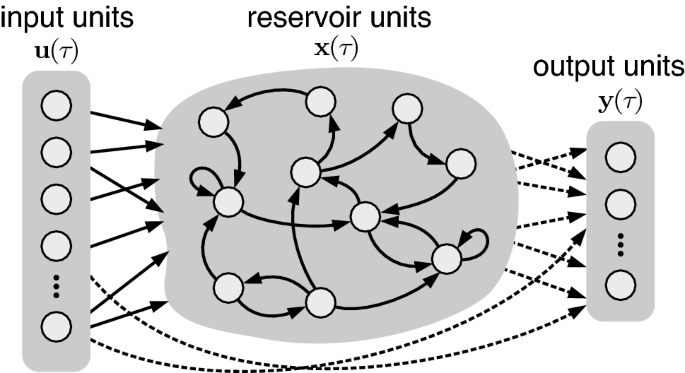

The Echo State Network is a type of Reservoir Computing model. The key feature of this model is the reservoir of neurons, which are randomly initialized and interconnected. The only weight-adjusting layer of this network is the output layer. This makes this model exceptionally good at understanding dynamical systems, making it perfect for modeling Chaos. Training and Testing an Echo State Network is a bit different then training a basic Nuerel Network. Rather then training the network on all the data at once then testing it, for an Echo State Network the training and testing are completed at the same time. First a set of window of input data is matched to an output value, then one instance of the testing set is used to test the model.

In [ ]:
!git clone https://github.com/cknd/pyESN.git

Cloning into 'pyESN'...
remote: Enumerating objects: 106, done.
remote: Total 106 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (106/106), 1.17 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
#!pip install nolds
!pip install tqdm

In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
#import nolds
from sklearn import preprocessing
from mpl_toolkits import mplot3d
from scipy.interpolate import splprep, splev
import math

from tqdm import tqdm


In [ ]:
'''

Echo State Network model for reservoir computing

'''




def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.

    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s

    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.

        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states

        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))


In [ ]:
'''

Set of several chaos metrics to characterize the visualized chaotic system

'''


def chaos_metrics(data):
  h = nolds.hurst_rs(data)
  rl = nolds.lyap_r(data)
  el = nolds.lyap_e(data)
  fd = nolds.corr_dim(data, 1)
  entropy = nolds.sampen(data)

  print("Hurst from nolds custom library", h)
  print("Rosenstein Lyapunov estimation from nolds custom library", rl)
  print("Eckmann Lyapunov estimation from nolds custom library", el)
  print("Fractal Dimension from nolds library", fd)
  print("Entropy from nolds library", entropy)

In [ ]:
'''

Functions for lorenz system

Inputs : A set of values and hyperparameters
Outputs : The derivatives of the system defined by the lorenz function

'''

def f_values(t, x, y, z, sig=.1):
  return sig*(y+z)
def g_values(t, x, y, z, p=.1):
  return x*(p - z)-y
def v_values(t, x, y, z, b=.1):
  return x*y - b*z




In [ ]:
'''

Calculates the k value given a list of functions defined by the differential equation.

Inputs : List of functions, list of points ex. (t0, x0, y0,...), (t1, x1, y1,...), ... etc
Outputs : List of K values for each respectives function

'''

def calculate_k(functions, current_points, h, hyper_parameters):
  t_o = current_points[0]
  x_o = current_points[1]
  y_o = current_points[2]
  z_o = current_points[3]

  x_function = functions[0]
  y_function = functions[1]
  z_function = functions[2]


  k1 = h*x_function(t_o, x_o, y_o, z_o, hyper_parameters[0])
  l1 = h*y_function(t_o, x_o, y_o, z_o, hyper_parameters[1])
  w1 = h*z_function(t_o, x_o, y_o, z_o, hyper_parameters[2])

  k2 = h*x_function(t_o+h/2, x_o+k1/2, y_o+l1/2, z_o+w1/2,  hyper_parameters[0])
  l2 = h*y_function(t_o+h/2, x_o+k1/2, y_o+l1/2, z_o+w1/2,  hyper_parameters[1])
  w2 = h*z_function(t_o+h/2, x_o+k1/2, y_o+l1/2, z_o+w1/2,  hyper_parameters[2])

  k3 = h*x_function(t_o+h/2, x_o+k2/2, y_o+l2/2, z_o+w2/2,  hyper_parameters[0])
  l3 = h*y_function(t_o+h/2, x_o+k2/2, y_o+l2/2, z_o+w2/2, hyper_parameters[1])
  w3 = h*z_function(t_o+h/2, x_o+k2/2, y_o+l2/2, z_o+w2/2, hyper_parameters[2])


  k4 = h*x_function(t_o+h, x_o+k3, y_o+l3, z_o+w3,  hyper_parameters[0])
  l4 = h*y_function(t_o+h, x_o+k3, y_o+l3, z_o+w3,  hyper_parameters[1])
  w4 = h*z_function(t_o+h, x_o+k3, y_o+l3, z_o+w3, hyper_parameters[2])



  return [k1 + 2*k2 + 2*k3 + k4,l1 + 2*l2 + 2*l3 + l4, w1 + 2*w2 + 2*w3 + w4]



In [ ]:
'''

Calculates the approximate n+1 value of the set of equations X, Y, Z from the initial conditions and set of derivative functions

Inputs : List of functions, list of points (tn, xn, yn,...)
Outputs : List of approximate values of Xn+1, Yn+1, Zn+1


'''

def approximate_function(functions, position, t, h=.001, hyper_parameters=[.001, .001, .001]):
  next_values = [t]
  k = calculate_k(functions, position, h, hyper_parameters)
  for i in range(len(functions)):
    next_values.append(position[i] + k[i]/6)
  return next_values



In [ ]:
'''

Loops through t values and calculates approximate points for Lorenz System
Input : List of functions, list of initial points, h=step size, hyper parameters
Output : List of approximate points utilizing the Runge-Kutta 4th Order method

'''
def generate_points(functions, initial_conditions, h, N, hyper_parameters):


  t_values = list(range(0, int(N), 1))

  values = []


  point = [0, 0, 0, 0]
  for t in t_values:
    if t == t_values[0]:
      point = approximate_function(functions, initial_conditions, t, h, hyper_parameters)
      values.append(point)
    else:
      next_point = approximate_function(functions, point, t, h,hyper_parameters)
      point = next_point
      values.append(point)
  return values






In [ ]:
'''

Input : A stock name variable
Output : An ESN model that is tuned to predicy on that stock

'''

def model_tuning(lorenz_points):

  n_reservoir= 300
  sparsity   = 0.2
  rand_seed  = 42

  radius_set = [0.5,0.7,0.9,1,1.1,1.3,1.5]
  noise_set = [0.0003,0.0007,0.001,0.003,0.005,0.007,0.01]
  sparsity_set = [.2,.3,.4,.5,.6]



  radius_set_size  = len(radius_set)
  noise_set_size = len(noise_set)
  sparsity_set_size = len(sparsity_set)


  loss = np.zeros([radius_set_size, noise_set_size, sparsity_set_size])

  refined_points=[]
  for i in range(len(lorenz_points)):
    refined_points.append(lorenz_points[i][1:4])
  for l in tqdm(range(radius_set_size)):
      rho = radius_set[l]
      for j in range(noise_set_size):
          noise = noise_set[j]
          for k in range(sparsity_set_size):
              ss = sparsity_set[k]

              esn = ESN(n_inputs = 3,
                n_outputs = 3,
                n_reservoir = n_reservoir,
                sparsity=ss,
                random_state=rand_seed,
                spectral_radius = rho,
                noise=noise)

              predictions = []
              mse = 0
              mse_length = 0
              #Generate Points
              for index in range(window+1, len(refined_points) - 1):
                x_in = np.array(refined_points[index-window-1:index-1])
                y_out = np.array(refined_points[index-window:index])
                x_a = np.array(refined_points[index])
                x_a = np.reshape(x_a, (1, x_a.shape[0]))

                prediction = get_prediction(esn, x_in, y_out, x_a)
                predictions.append(prediction[0])

                mse += (sum(prediction[0]-refined_points[index+1]))**2
                mse_length += 1

              score = math.sqrt(mse/mse_length/3)
              #print(score)

              loss[l, j, k] = score
              print('rho = ', radius_set[l], ', noise = ', noise_set[j], ', sparsity = ', sparsity_set[k], ', Score = ', loss[l][j][k] )
  min_loss_index = np.unravel_index(loss.argmin(), loss.shape)
  #print(min_loss_index)
  tuned_esn = ESN(n_inputs = 3,
          n_outputs = 3,
          n_reservoir = n_reservoir,
          sparsity=sparsity_set[min_loss_index[2]],
          random_state=23,
          spectral_radius=radius_set[min_loss_index[0]],
          noise = noise_set[min_loss_index[1]])
  print("Sparsity ", min_loss_index[2], " Spectral Radius ", min_loss_index[0], " Noise ", min_loss_index[1])
  return tuned_esn

In [ ]:
'''

For ESN model. Trains the model on the most current data - window, then predicts on the current data point

Input : model (esn), training data, training output data, actual input for prediction
Output : Prediction from the model

'''

def get_prediction(model, train_input, train_output, actual_input):
  model.fit(np.array(train_input), np.array(train_output))
  return model.predict(actual_input)





Model Tuning


In [ ]:
window = 100
hyper_parameters = [0, 0, 10]
functions = [f_values, g_values, v_values]
initial_conditions = [.1, .1, .1, .1]
N = 1000.0
h = 1/N

lorenz_points_tuning = generate_points(functions=functions, initial_conditions=initial_conditions,h=h,N=N,hyper_parameters=hyper_parameters)
lorenz_points_tuning = preprocessing.scale(lorenz_points_tuning)

tuned_esn = model_tuning(lorenz_points_tuning)

  0%|          | 0/7 [00:00<?, ?it/s]

rho =  0.5 , noise =  0.0003 , sparsity =  0.2 , Score =  0.44828610656980045
rho =  0.5 , noise =  0.0003 , sparsity =  0.3 , Score =  0.4360554436017507
rho =  0.5 , noise =  0.0003 , sparsity =  0.4 , Score =  0.4375029914789934
rho =  0.5 , noise =  0.0003 , sparsity =  0.5 , Score =  0.4357965133093048
rho =  0.5 , noise =  0.0003 , sparsity =  0.6 , Score =  0.4484681640816643
rho =  0.5 , noise =  0.0007 , sparsity =  0.2 , Score =  0.4623311907489077
rho =  0.5 , noise =  0.0007 , sparsity =  0.3 , Score =  0.4528896292529491
rho =  0.5 , noise =  0.0007 , sparsity =  0.4 , Score =  0.45073999858358205
rho =  0.5 , noise =  0.0007 , sparsity =  0.5 , Score =  0.4517989499648373
rho =  0.5 , noise =  0.0007 , sparsity =  0.6 , Score =  0.4615702898022431
rho =  0.5 , noise =  0.001 , sparsity =  0.2 , Score =  0.466494097126986
rho =  0.5 , noise =  0.001 , sparsity =  0.3 , Score =  0.45888776340056914
rho =  0.5 , noise =  0.001 , sparsity =  0.4 , Score =  0.4550050108771824


 14%|█▍        | 1/7 [11:17<1:07:42, 677.02s/it]

rho =  0.5 , noise =  0.01 , sparsity =  0.6 , Score =  0.47527341129471745
rho =  0.7 , noise =  0.0003 , sparsity =  0.2 , Score =  0.4720575480854861
rho =  0.7 , noise =  0.0003 , sparsity =  0.3 , Score =  0.45717602055957884
rho =  0.7 , noise =  0.0003 , sparsity =  0.4 , Score =  0.45157579970430217
rho =  0.7 , noise =  0.0003 , sparsity =  0.5 , Score =  0.44858009371006424
rho =  0.7 , noise =  0.0003 , sparsity =  0.6 , Score =  0.457007246242472
rho =  0.7 , noise =  0.0007 , sparsity =  0.2 , Score =  0.47678568772155494
rho =  0.7 , noise =  0.0007 , sparsity =  0.3 , Score =  0.4648485546795634
rho =  0.7 , noise =  0.0007 , sparsity =  0.4 , Score =  0.4598986076147434
rho =  0.7 , noise =  0.0007 , sparsity =  0.5 , Score =  0.4584848703926472
rho =  0.7 , noise =  0.0007 , sparsity =  0.6 , Score =  0.4670499235999881
rho =  0.7 , noise =  0.001 , sparsity =  0.2 , Score =  0.47793188491815386
rho =  0.7 , noise =  0.001 , sparsity =  0.3 , Score =  0.467894706497318

 29%|██▊       | 2/7 [21:52<54:23, 652.74s/it]  

rho =  0.7 , noise =  0.01 , sparsity =  0.6 , Score =  0.4797297645929388
rho =  0.9 , noise =  0.0003 , sparsity =  0.2 , Score =  0.4890145696061752
rho =  0.9 , noise =  0.0003 , sparsity =  0.3 , Score =  0.471642835307595
rho =  0.9 , noise =  0.0003 , sparsity =  0.4 , Score =  0.465206674091404
rho =  0.9 , noise =  0.0003 , sparsity =  0.5 , Score =  0.45928588720321367
rho =  0.9 , noise =  0.0003 , sparsity =  0.6 , Score =  0.46629509592476726
rho =  0.9 , noise =  0.0007 , sparsity =  0.2 , Score =  0.4921391535004763
rho =  0.9 , noise =  0.0007 , sparsity =  0.3 , Score =  0.47506224581072853
rho =  0.9 , noise =  0.0007 , sparsity =  0.4 , Score =  0.4700978750663522
rho =  0.9 , noise =  0.0007 , sparsity =  0.5 , Score =  0.4671346463090694
rho =  0.9 , noise =  0.0007 , sparsity =  0.6 , Score =  0.47505721395994094
rho =  0.9 , noise =  0.001 , sparsity =  0.2 , Score =  0.49257501150977795
rho =  0.9 , noise =  0.001 , sparsity =  0.3 , Score =  0.47709313565478856

 43%|████▎     | 3/7 [32:31<43:05, 646.27s/it]

rho =  0.9 , noise =  0.01 , sparsity =  0.6 , Score =  0.4844138544027922
rho =  1 , noise =  0.0003 , sparsity =  0.2 , Score =  0.493282191068979
rho =  1 , noise =  0.0003 , sparsity =  0.3 , Score =  0.4789903921908352
rho =  1 , noise =  0.0003 , sparsity =  0.4 , Score =  0.4705270684471475
rho =  1 , noise =  0.0003 , sparsity =  0.5 , Score =  0.4662479367967458
rho =  1 , noise =  0.0003 , sparsity =  0.6 , Score =  0.4722586817460349
rho =  1 , noise =  0.0007 , sparsity =  0.2 , Score =  0.4942760326640186
rho =  1 , noise =  0.0007 , sparsity =  0.3 , Score =  0.47795095939203935
rho =  1 , noise =  0.0007 , sparsity =  0.4 , Score =  0.4723652670719557
rho =  1 , noise =  0.0007 , sparsity =  0.5 , Score =  0.47086785531878644
rho =  1 , noise =  0.0007 , sparsity =  0.6 , Score =  0.4802413742902434
rho =  1 , noise =  0.001 , sparsity =  0.2 , Score =  0.4940375042311691
rho =  1 , noise =  0.001 , sparsity =  0.3 , Score =  0.47887636986441423
rho =  1 , noise =  0.001

 57%|█████▋    | 4/7 [42:59<31:57, 639.05s/it]

rho =  1 , noise =  0.01 , sparsity =  0.6 , Score =  0.48765686678824066
rho =  1.1 , noise =  0.0003 , sparsity =  0.2 , Score =  0.49363204644861763
rho =  1.1 , noise =  0.0003 , sparsity =  0.3 , Score =  0.48520284492513027
rho =  1.1 , noise =  0.0003 , sparsity =  0.4 , Score =  0.47411430968040313
rho =  1.1 , noise =  0.0003 , sparsity =  0.5 , Score =  0.4720508270287185
rho =  1.1 , noise =  0.0003 , sparsity =  0.6 , Score =  0.4802629313919659
rho =  1.1 , noise =  0.0007 , sparsity =  0.2 , Score =  0.4940667396603294
rho =  1.1 , noise =  0.0007 , sparsity =  0.3 , Score =  0.4839237014309531
rho =  1.1 , noise =  0.0007 , sparsity =  0.4 , Score =  0.47381690172149715
rho =  1.1 , noise =  0.0007 , sparsity =  0.5 , Score =  0.4756264907661042
rho =  1.1 , noise =  0.0007 , sparsity =  0.6 , Score =  0.48705033594556446
rho =  1.1 , noise =  0.001 , sparsity =  0.2 , Score =  0.49386638192010285
rho =  1.1 , noise =  0.001 , sparsity =  0.3 , Score =  0.483549749966473

 71%|███████▏  | 5/7 [53:29<21:11, 635.89s/it]

rho =  1.1 , noise =  0.01 , sparsity =  0.6 , Score =  0.49171087655995077
rho =  1.3 , noise =  0.0003 , sparsity =  0.2 , Score =  0.48743970909016593
rho =  1.3 , noise =  0.0003 , sparsity =  0.3 , Score =  0.48792313950452704
rho =  1.3 , noise =  0.0003 , sparsity =  0.4 , Score =  0.4788688766231332
rho =  1.3 , noise =  0.0003 , sparsity =  0.5 , Score =  0.4832654440812841
rho =  1.3 , noise =  0.0003 , sparsity =  0.6 , Score =  0.48792106300572907
rho =  1.3 , noise =  0.0007 , sparsity =  0.2 , Score =  0.4878672824657529
rho =  1.3 , noise =  0.0007 , sparsity =  0.3 , Score =  0.4914838788075315
rho =  1.3 , noise =  0.0007 , sparsity =  0.4 , Score =  0.47805034257886747
rho =  1.3 , noise =  0.0007 , sparsity =  0.5 , Score =  0.4854066549607729
rho =  1.3 , noise =  0.0007 , sparsity =  0.6 , Score =  0.4942033446189206
rho =  1.3 , noise =  0.001 , sparsity =  0.2 , Score =  0.48797457566109304
rho =  1.3 , noise =  0.001 , sparsity =  0.3 , Score =  0.49330256587920

 86%|████████▌ | 6/7 [1:03:57<10:33, 633.08s/it]

rho =  1.3 , noise =  0.01 , sparsity =  0.6 , Score =  0.4998914894349377
rho =  1.5 , noise =  0.0003 , sparsity =  0.2 , Score =  0.4949222007314632
rho =  1.5 , noise =  0.0003 , sparsity =  0.3 , Score =  0.4920955853015873
rho =  1.5 , noise =  0.0003 , sparsity =  0.4 , Score =  0.4902931219147605
rho =  1.5 , noise =  0.0003 , sparsity =  0.5 , Score =  0.49772231494038466
rho =  1.5 , noise =  0.0003 , sparsity =  0.6 , Score =  0.4900583582993845
rho =  1.5 , noise =  0.0007 , sparsity =  0.2 , Score =  0.4923752581084204
rho =  1.5 , noise =  0.0007 , sparsity =  0.3 , Score =  0.4935217057816543
rho =  1.5 , noise =  0.0007 , sparsity =  0.4 , Score =  0.487136863314805
rho =  1.5 , noise =  0.0007 , sparsity =  0.5 , Score =  0.49964034671640106
rho =  1.5 , noise =  0.0007 , sparsity =  0.6 , Score =  0.4924136547062118
rho =  1.5 , noise =  0.001 , sparsity =  0.2 , Score =  0.49144193792421126
rho =  1.5 , noise =  0.001 , sparsity =  0.3 , Score =  0.49557046785400966


100%|██████████| 7/7 [1:14:23<00:00, 637.57s/it]

rho =  1.5 , noise =  0.01 , sparsity =  0.6 , Score =  0.5002163484109974
Sparsity  3  Spectral Radius  0  Noise  0


Test on tuned model


In [ ]:

#Mean squared error
mse = 0
mse_length = 0

predictions = []


#Generate Points

lorenz_points = generate_points(functions=functions, initial_conditions=initial_conditions,h=h,N=N,hyper_parameters=hyper_parameters)
lorenz_points = preprocessing.scale(lorenz_points)
refined_points=[]
for i in range(len(lorenz_points)):
  refined_points.append(lorenz_points[i][1:4])

for index in tqdm(range(window+1, len(refined_points) - 1)):
  x_in = np.array(refined_points[index-window-1:index-1])
  y_out = np.array(refined_points[index-window:index])
  x_a = np.array(refined_points[index])
  x_a = np.reshape(x_a, (1, x_a.shape[0]))

  prediction = get_prediction(tuned_esn, x_in, y_out, x_a)
  predictions.append(prediction[0])

  mse += (sum(prediction[0]-refined_points[index+1]))**2
  mse_length += 1


print('Mean Squared Error', math.sqrt(mse/mse_length/3))

100%|██████████| 898/898 [00:19<00:00, 46.07it/s]

Mean Squared Error 0.42961267586297947


In [ ]:
print(len(refined_points))

1000


Visualize Results

Try to reduce the number of points because model seems to peform better before chaotic system grows expontnetially

In [ ]:
'''

Break down values list into x,y,z values

'''
t_values = []
x_values = []
y_values = []
z_values = []

for i in range(5, len(refined_points)):
  t_values.append(i)
  x_values.append(refined_points[i][0])
  y_values.append(refined_points[i][1])
  z_values.append(refined_points[i][2])

t_values = np.array(t_values)

In [ ]:
'''

Break down values list into x,y,z values

'''
t_values_prediction = []
x_values_prediction = []
y_values_prediction = []
z_values_prediction = []

for i in range(5, len(predictions)):
  t_values_prediction.append(i)
  x_values_prediction.append(predictions[i][0])
  y_values_prediction.append(predictions[i][1])
  z_values_prediction.append(predictions[i][2])

t_values = np.array(t_values_prediction)

<ipython-input-35-188d3bc02fee>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x_new_prediction, y_new_prediction, z_new_prediction, 'b-', label='Prediction',  linewidth=0.5, color='red')


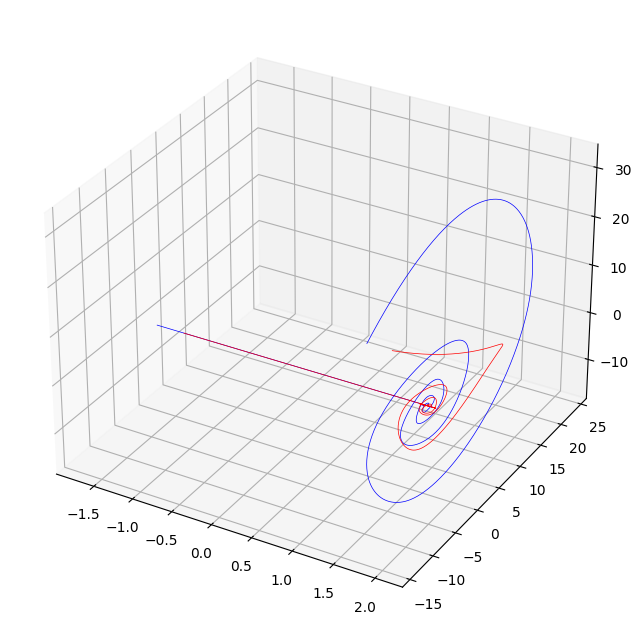

In [ ]:
'''

3D Plot of the Lorenz System vs 3D Plot of Prediction

'''

tck, u = splprep([x_values, y_values, z_values], s=1)
u_new = np.linspace(0, 1, len(t_values))

x_new, y_new, z_new = splev(u_new, tck)

tck_prediction, u_prediction = splprep([x_values_prediction, y_values_prediction, z_values_prediction], s=1)
u_new_prediction = np.linspace(0, 1, len(t_values_prediction))

x_new_prediction, y_new_prediction, z_new_prediction = splev(u_new_prediction, tck_prediction)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_new, y_new, z_new, 'b-', label='Actual',  linewidth=0.5)
ax.plot(x_new_prediction, y_new_prediction, z_new_prediction, 'b-', label='Prediction',  linewidth=0.5, color='red')
